# Whisper Transcribe
OpenAI Whisper test and evaluation for German language audio files.

DUT 1:
* Nvidia RTX 3070 (8GB)
* 64GB RAM

DUT 2:
* Inter Core i7 (4-core 2.7 GHz)
* 16GB RAM

## Execution
For the different available models, perform transcription and match the output to the manual transcript.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import whisper
from datetime import datetime
from difflib import SequenceMatcher

In [2]:
# init SequenceMatcher
similar = lambda a, b: SequenceMatcher(None, a, b).ratio()

# init metadata
audio_file = os.path.join(os.getcwd(), '20221007_stochastik_zufall.m4a')  # path to file
audio_length = 22  # seconds
manual_transcript = """Zufall ist, in unserem Kontext, nicht ein im Hintergrund unseres Daseins wirkendes Prinzip, das unser Leben zu beeinträchtigen in der Lage ist, sondern das Wort dient zur Charakterisierung einer Situation, in der wir auf Grund fehlender Informationen den Ausgang eines Experiments nicht vorhersehen können."""
language_whisper = "German"
device = "cuda" if torch.cuda.is_available() else "cpu"

# init dataframe
results_df = pd.DataFrame({
    "Model": ["tiny", "base", "small", "medium", "large"],
    "Memory Needed": [1073741824, 1073741824, 2147483648, 5368709120, 10737418240],  # necessary VRAM in Bytes
    "Language": "German",
    "Manual Transcript": manual_transcript,
    "Audio Length": audio_length,
    "Whisper Transcript": str(),
    "Transcription Duration": np.nan,   # duration in s
    "t-t Factor": np.nan,               # duration / audio length
    "Match": np.nan                     # match in %
})

In [5]:
idx = 0

for w_model in results_df.Model:
    # check if model exceeds memory available if gpu is used
    if device == "cuda" and results_df.iloc[idx, 1] >= int(torch.cuda.get_device_properties(0).total_memory):
        print(f"Skipping for model {w_model} (Not enough GPU Memory)")
        continue
    
    # load model
    model = whisper.load_model(w_model, device=device)  # select model: tiny, base, small, medium, large
    
    timestamp_start = datetime.now()
    result = model.transcribe(audio_file, language=language_whisper)
    timestamp_end = datetime.now()

    results_df.iloc[idx, 5] = result['text']
    results_df.iloc[idx, 6] = (timestamp_end - timestamp_start).seconds
    results_df.iloc[idx, 7] = round(results_df.iloc[idx, 6]/audio_length, 2)
    results_df.iloc[idx, 8] = round(similar(manual_transcript, result['text']) * 100, 2)
    
    idx += 1

print(results_df[["Model", "Transcription Duration", "t-t Factor", "Match"]])

Skipping for model large (Not enough GPU Memory)
    Model  Transcription Duration  t-t Factor  Match
0    tiny                     1.0        0.05  80.59
1    base                     1.0        0.05  96.20
2   small                     2.0        0.09  98.52
3  medium                     4.0        0.18  99.18
4   large                     NaN         NaN    NaN


## Evaluation

Evaluation and visualization of the outcome.
All values are to be understood as averages of 100 trials.

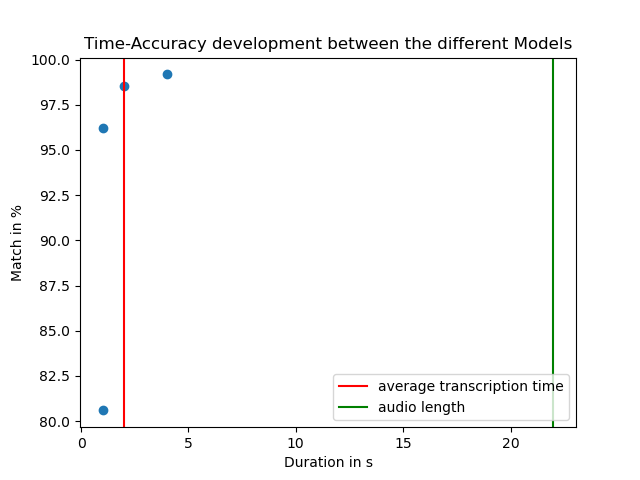

In [6]:
transcription_time_avg = np.mean(results_df["Transcription Duration"])

%matplotlib widget
plt.scatter(results_df["Transcription Duration"], results_df["Match"])
plt.axvline(transcription_time_avg, color="red", label="average transcription time")
plt.axvline(audio_length, color="green", label="audio length")
plt.legend(loc="lower right")
plt.xlabel("Duration in s")
plt.ylabel("Match in %")
plt.title("Time-Accuracy development between the different Models")
plt.show()

# Result

### CPU

For the CPU device research has shown, that the small model offers the best time-match tradeoff with a time factor of only 1:1.64 and a accuracy of 98.5%. Interestingly, the large model performed worse than the medium one, although needing nearly twice as much time.

### GPU

The GPU outperformed the CPU by far, needing only a fraction of the time the CPU needed.